# Data Mining and Visualisation -- Lab 4

In this lab, you will have a go at exploring a new dataset that has been added to the MyAberdeen Datasets folder, and will work through a popular Kaggle script to undertake an A/B test on a real-life mobile game: Cookie Cats.

Source: This data was originally from a [Data Camp project](https://www.datacamp.com/projects/184), and has since been made available (and has been the subject of various analyses) on [Kaggle](https://www.kaggle.com/datasets/yufengsui/mobile-games-ab-testing). 

The below source code that we will be working through is from Kaggle users [serdarozturk](https://www.kaggle.com/code/serdarsozturk/a-b-mobilegame) and [muhammetgamal5](https://www.kaggle.com/code/muhammetgamal5/cookie-cats-a-b-testing-p-value), taking the best of both scripts to explore the EDA, data pre-processing, and statistical testing process.

___

## A/B MobileGame /ᐠ｡ꞈ｡ᐟ\ 

The process of decision making in design has always been a popular area of discussion. Why do some designers make choices that others don’t, and why do some designs seemingly work better than others?

From academic study to sketches and anecdotes, the design world is fascinated with process. But for all of the legendary stories of lore, few anecdotes in recent times have had the staying power of Google and its 41 shades of blue.

In trying to determine which out of 2 shades of blue to use for link text, Google tested not only the 2, but also the 39 shades of blue in between. The story outlines a relatively minute decision but highlights a rapidly growing approach to making decisions. One based in experimentation, alternatives, and, most importantly, data.



1. Define your conversion goal. In this example, you want to measure click-through rate. 

2. Design the A/B test. How big of a sample size do you want? Who will participate, new customers or existing customers? 

3. Gather data. Will you run your own test or use A/B testing software? For how long will the test run?

4. Analyze the results. Which variation had the biggest positive impact on the conversion metric that matters most? 



**AB Testing Process**

* Understanding business problem & data
* Detect and resolve problems in the data (Missing Value, Outliers, Unexpected Value)
* Look summary stats and plots
* Apply hypothesis testing and check assumptions
* Check Normality & Homogeneity
* Apply tests (Shapiro, Levene Test, T-Test, Welch Test, Mann Whitney U Test)
* Evaluate the results
* Make inferences
* Recommend business decision to your customer/director/ceo etc.





#### Descriptions: The data is about an A/B test with a mobile game called "Cookie Cats".

Cookie Cats is a hugely popular mobile puzzle game developed by Tactile Entertainment. It's a classic "connect three" style puzzle game where the player must connect tiles of the same color in order to clear the board and win the level. It also features singing cats. We're not kidding!

As players progress through the game they will encounter gates that force them to wait some time before they can progress or make an in-app purchase. In this project, we will analyze the result of an A/B test where the first gate in Cookie Cats was moved from level 30 to level 40. In particular, we will analyze the impact on player retention and game rounds.

To complete this project, you should be comfortable working with pandas DataFrames and with using the pandas plot method. You should also have some understanding of hypothesis testing and bootstrap analysis.


#### Dataset columns descriptions:

* `userid`: A unique number that identifies each player.
* `version`: Whether the player was put in the control group (gate_30 - a gate at level 30) or the group with the moved gate (gate_40 - a gate at level 40).
* `sum_gamerounds`: The number of game rounds played by the player during the first 14 days after install.
* `retention_1`: Did the player come back and play 1 day after installing?
* `retention_7`: Did the player come back and play 7 days after installing?


#### Question:

*  Should we keep using the old version for cookie cats game or release the new version? 

###  Packages-Libraries-Settings

In [33]:
#!pip install statsmodels
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
palette = 'Set2'
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
import statsmodels.stats.api as sms
from scipy.stats import ttest_1samp, shapiro, levene, ttest_ind, mannwhitneyu, \
    pearsonr, spearmanr, kendalltau, f_oneway, kruskal, normaltest
from statsmodels.stats.proportion import proportions_ztest

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)
pd.set_option('display.width', 180)
pd.set_option('display.float_format', lambda x: '%.5f' % x)


# Make sure that our plots are visualised in jupyter
%matplotlib inline


### Data Wrangling

 **This is a three step process:**

*  Gathering the data from Dataset and investegate it trying to understand more details about it. 
*  Assessing data to identify any issues with data types, structure, or quality.
*  Cleaning data by changing data types, replacing values, removing unnecessary data and modifying Dataset for easy and fast analysis.


The Cookie Cats A/B test data is available in the MyAberdeen datasets folder:  `cookie_cats.csv`.

In [34]:
df = pd.read_csv("cookie_cats.csv")

df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


### Assessing Data

In [35]:
#checking Dataframe basic informations (columns names, number of values, data types ......)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [36]:
#checking Dataframe shape (number of rows and columns)

df.shape

(90189, 5)

In [37]:
# checking for NaN values patients

df.isnull().sum()

userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64

In [38]:
#checking for duplicated rows 

df.duplicated().sum()

0

In [39]:
# checking for duplicated with subset 

df.userid.duplicated().sum()

0

### Exploratory Data Analysis

Now I'm going to explore this dataset.


In [40]:
# Counting the number of players in each group.
df.groupby("version")["userid"].count()

version
gate_30    44700
gate_40    45489
Name: userid, dtype: int64

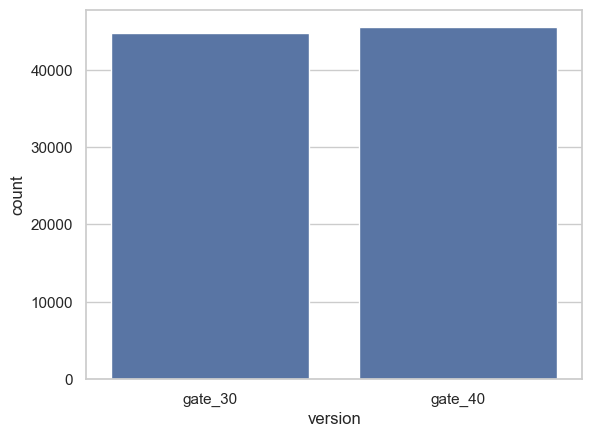

In [41]:
sns.countplot(x="version",data=df);

In [42]:
# Counting the retention_1 proptions in each group.
df.groupby("version")["retention_1"].mean()

version
gate_30   0.44819
gate_40   0.44228
Name: retention_1, dtype: float64

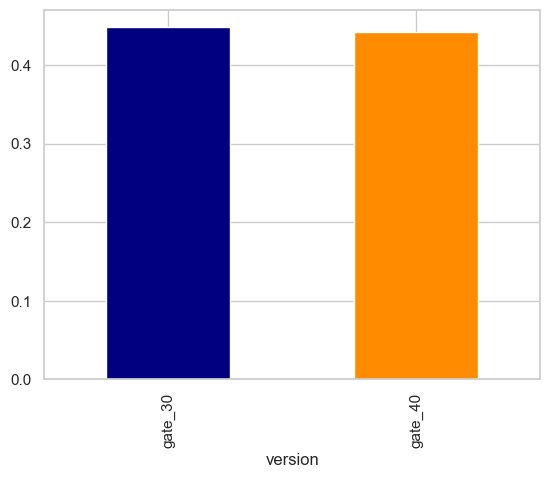

In [43]:
df.groupby("version")["retention_1"].mean().plot(kind="bar", color=[ "navy", "darkorange"]);

In [44]:
# Counting the retention_7 proptions in each group.
df.groupby("version")["retention_7"].mean()

version
gate_30   0.19020
gate_40   0.18200
Name: retention_7, dtype: float64

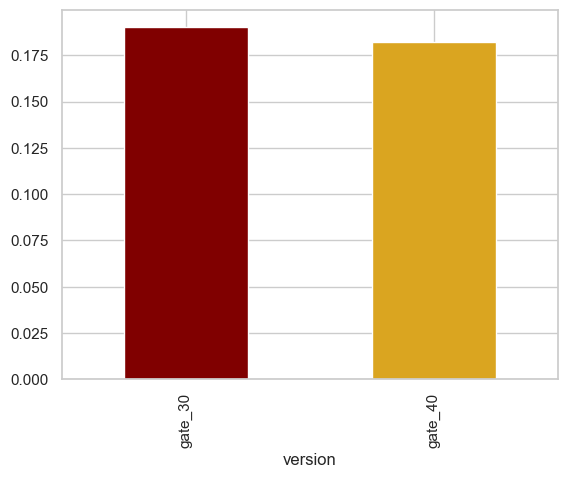

In [45]:
df.groupby("version")["retention_7"].mean().plot(kind="bar", color=[ "maroon", "goldenrod"]);

In [46]:
# Counting the sum_gamerounds means in each group.
df.groupby("version")["sum_gamerounds"].mean()

version
gate_30   52.45626
gate_40   51.29878
Name: sum_gamerounds, dtype: float64

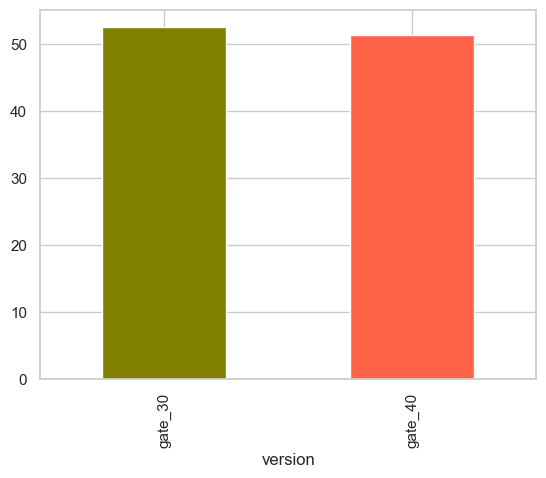

In [47]:
df.groupby("version")["sum_gamerounds"].mean().plot(kind="bar", color=[ "olive", "tomato"]);

Retention variables gives us player retention details.

* retention_1 - did the player come back and play 1 day after installing?
* retention_7 - did the player come back and play 7 days after installing?
Also players tend not to play the game! There are many players who quit the game.

* 55 percent of the players didn't play the game 1 day after insalling
* 81 percent of the players didn't play the game 7 day after insalling

In [48]:
df['sum_gamerounds'].sort_values()

45094        0
56753        0
56786        0
56834        0
56876        0
         ...  
48188     2294
43671     2438
29417     2640
7912      2961
57702    49854
Name: sum_gamerounds, Length: 90189, dtype: int64

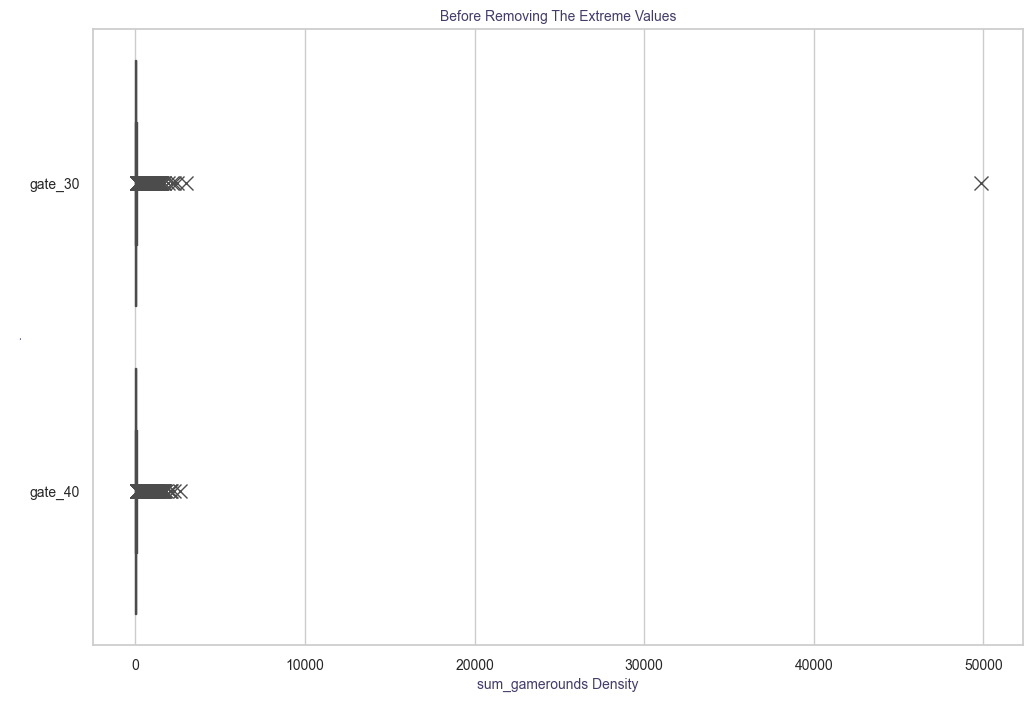

In [49]:
fig, ax = plt.subplots(figsize = (12, 8), facecolor = "#FFFFFF")
ax.set_facecolor("#FFFFFF")

sns.boxplot(data=df, x="sum_gamerounds", y="version", hue="version", dodge=False,
            flierprops={"marker": "x"}, width=.8, fliersize=10)
plt.title('Before Removing The Extreme Values', size = 10, color='#443C68')
plt.ylabel('.', size = 10,color="#443C68" )
plt.xlabel('sum_gamerounds Density', fontsize = 10,color="#443C68" )
plt.xticks(size = 10)
plt.yticks(size = 10)
plt.show()

As can be seen from the data, there are outliers in the sum_gamerounds column. What if we set up our hypotheses without clearing out the outliers? Let's see... 


### A/B Testing Before Removing The Extreme Values 

H0: Distribution is Normal! 

H1: Distribution is not Normal! 

H0: M1 = M2

H1: M1 != M2


In [50]:
df['userid'].nunique()

90189

In [51]:
# A/B Groups & Target Summary Stats
df.groupby("version").agg({'sum_gamerounds': ["count", "median", "mean", "std", "max"]})

sum_gamerounds                                   
                 count   median     mean       std    max
version                                                  
gate_30          44700 17.00000 52.45626 256.71642  49854
gate_40          45489 16.00000 51.29878 103.29442   2640

#### Verifying whether our data meets the required assumptions to run a t-test.

A standard t-test requires the data to meet certain criteria in order to be an appropriate test to use. In this script, we will focus on the following two assumptions:

- **Normality**: Both samples are approximately normally distributed.
- **Homogeneity of Variances**: Both samples have approximately the same variance.

If these assumptions are not met, then a different version of the test (known as a non-parametric version of the t-test) will need to be used instead.

#### Normality

In [52]:
print("\033[1msum_gamerounds normality for gate 40: \n\033[0m")
test_stat, pvalue = shapiro(df.loc[df["version"] == "gate_30", "sum_gamerounds"])
print('Test Stat = %.4f, p-value = %.4f' % (test_stat, pvalue))

print("\033[1mOur series is not normally distributed. \n\033[0m")

sum_gamerounds normality for gate 40: 

Test Stat = 0.0881, p-value = 0.0000
Our series is not normally distributed. 



In [53]:
print("\033[1msum_gamerounds normality for gate 40: \n\033[0m")
test_stat, pvalue = shapiro(df.loc[df["version"] == "gate_40", "sum_gamerounds"])
print('Test Stat = %.4f, p-value = %.4f' % (test_stat, pvalue))

print("\033[1mOur series is not normally distributed. \n\033[0m")

sum_gamerounds normality for gate 40: 

Test Stat = 0.4826, p-value = 0.0000
Our series is not normally distributed. 



#### Homogeneity of variances


In [54]:
print("\033[1msum_gamerounds normality for gate 30 and gate 40: \n\033[0m")


test_stat, pvalue = levene(df.loc[df["version"] == "gate_30", "sum_gamerounds"],
                           df.loc[df["version"] == "gate_40", "sum_gamerounds"])
print('Test Stat = %.4f, p-value = %.4f' % (test_stat, pvalue))


print("\033[1mOur series is not homogen. \n\033[0m")

sum_gamerounds normality for gate 30 and gate 40: 

Test Stat = 0.5292, p-value = 0.4669
Our series is not homogen. 



In [55]:
#non-parametrik test
test_stat, pvalue = mannwhitneyu(df.loc[df["version"] == "gate_30", "sum_gamerounds"],
                                 df.loc[df["version"] == "gate_40", "sum_gamerounds"])

print('Test Stat = %.4f, p-value = %.4f' % (test_stat, pvalue))

print("\033[1mWe can not reject H0 hypothesis, "
              "so that A/B groups are similar!.\n\033[0m")


Test Stat = 1024331250.5000, p-value = 0.0502
We can not reject H0 hypothesis, so that A/B groups are similar!.



### A/B Testing After Removing The Extreme Values

H0: Distribution is Normal!

H1: Distribution is not Normal!

H0: M1 = M2

H1: M1 != M2


In [56]:

df = df[df.sum_gamerounds < df.sum_gamerounds.max()]
df['sum_gamerounds'].describe()

count   90188.00000
mean       51.32025
std       102.68272
min         0.00000
25%         5.00000
50%        16.00000
75%        51.00000
max      2961.00000
Name: sum_gamerounds, dtype: float64

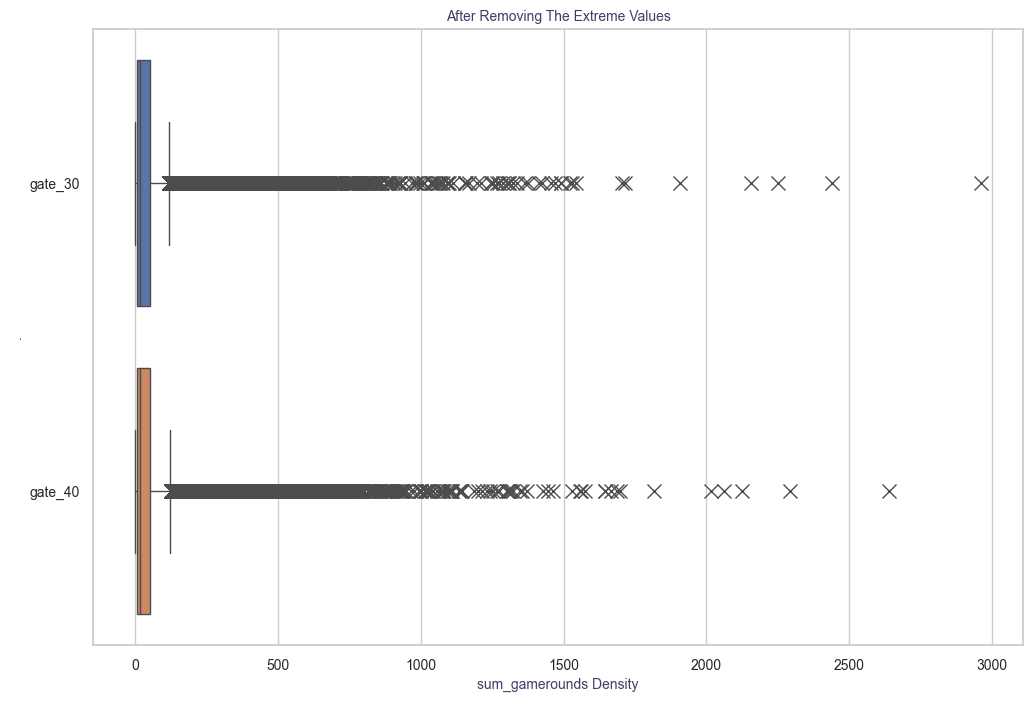

In [57]:
fig, ax = plt.subplots(figsize = (12, 8), facecolor = "#FFFFFF")
ax.set_facecolor("#FFFFFF")

sns.boxplot(data=df, x="sum_gamerounds", y="version", hue="version", dodge=False,
            flierprops={"marker": "x"}, width=.8, fliersize=10)
plt.title('After Removing The Extreme Values', size = 10, color='#443C68')
plt.ylabel('.', size = 10,color="#443C68" )
plt.xlabel('sum_gamerounds Density', fontsize = 10,color="#443C68" )
plt.xticks(size = 10)
plt.yticks(size = 10)
plt.show()


In [58]:
# What is the confidence interval for the 'REVENUE' value?

sms.DescrStatsW(df["sum_gamerounds"]).tconfint_mean()

(50.650095717882365, 51.990410779656116)

In [59]:
df.groupby('version').agg({'sum_gamerounds': ['sum', 'count']}).reset_index()

version sum_gamerounds       
                      sum  count
0  gate_30        2294941  44699
1  gate_40        2333530  45489

#### Normality

In [60]:
print("\033[1msum_gamerounds normality for gate 40: \n\033[0m")
test_stat, pvalue = shapiro(df.loc[df["version"] == "gate_30", "sum_gamerounds"])
print('Test Stat = %.4f, p-value = %.4f' % (test_stat, pvalue))

print("\033[1mOur series is not normally distributed. \n\033[0m")

sum_gamerounds normality for gate 40: 

Test Stat = 0.4886, p-value = 0.0000
Our series is not normally distributed. 



In [61]:
print("\033[1msum_gamerounds normality for gate 40: \n\033[0m")
test_stat, pvalue = shapiro(df.loc[df["version"] == "gate_40", "sum_gamerounds"])
print('Test Stat = %.4f, p-value = %.4f' % (test_stat, pvalue))


print("\033[1mOur series is not normally distributed. \n\033[0m")


sum_gamerounds normality for gate 40: 

Test Stat = 0.4826, p-value = 0.0000
Our series is not normally distributed. 



#### Homogeneity of variances


In [62]:
print("\033[1msum_gamerounds normality for gate 30 and gate 40: \n\033[0m")


test_stat, pvalue = levene(df.loc[df["version"] == "gate_30", "sum_gamerounds"],
                           df.loc[df["version"] == "gate_40", "sum_gamerounds"])
print('Test Stat = %.4f, p-value = %.4f' % (test_stat, pvalue))

print("\033[1mOur variance of series is homogen. \n\033[0m")


sum_gamerounds normality for gate 30 and gate 40: 

Test Stat = 0.0751, p-value = 0.7840
Our variance of series is homogen. 



In [63]:
#non-parametrik test
test_stat, pvalue = mannwhitneyu(df.loc[df["version"] == "gate_30", "sum_gamerounds"],
                                 df.loc[df["version"] == "gate_40", "sum_gamerounds"])

print('Test Stat = %.4f, p-value = %.4f' % (test_stat, pvalue))

print("\033[1mWe can not reject H0 hypothesis, "
              "so that A/B groups are similar!.\n\033[0m")

Test Stat = 1024285761.5000, p-value = 0.0509
We can not reject H0 hypothesis, so that A/B groups are similar!.




### Conclusion:

If we need to summarise briefly;

- We apply Mann Whitney U test for comparing sum_gamerounds for both versions.
 
- For Mann Whitney U test, we don't have statistically significant difference between groups. They have similar sum_gamerounds.
      
- The Mann Whitney U test I ran before cleaning out the outliers yielded p_value=0.0502. 
          
- When I cleared the maximum value, p_value=0.0509 appeared. In this case, we can say that the H0 hypothesis cannot be rejected. 
               
- However, in order to reach a clearer conclusion, it is necessary to perform A/B test on a larger data set. In addition, a larger change to the outliers may reduce the yyy value to less than 0.05.

---

The above code is from Kaggle users [serdarozturk](https://www.kaggle.com/code/serdarsozturk/a-b-mobilegame) and [muhammetgamal5](https://www.kaggle.com/code/muhammetgamal5/cookie-cats-a-b-testing-p-value).

Hopefully this bonus lecture and lab gave you a flavour for how A/B tests can be run in practice. They are a common method of optimising various aspects websites, apps, games, etc. and it is useful to see how some Kaggle users approach the EDA, data pre-processing, and statistical testing steps when working with a new script.

## New challenge

Try applying some of the above functions and methods you've learned to one of the other datasets on MyAberdeen!